In [195]:
import cv2
import numpy as np
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from skimage.feature import blob_dog, blob_log, blob_doh, canny
from skimage.morphology import binary_dilation, binary_erosion,binary_opening,binary_closing
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import erosion, dilation, opening, closing
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters import gaussian


In [196]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [197]:
def isRect(contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    a1 = cv2.contourArea(contour)
    a2 = w*h
    diff = abs(a1-a2)
    return (diff < (0.35 * a1))


In [198]:
def preprocess(img):
    gray = None
    if img.shape[2] == 4:
        gray = rgb2gray(rgba2rgb(img))
    else:
        gray = rgb2gray(img)
    gfilter = gaussian(gray)
    gfilter[gfilter < 0.5] = 0
    gfilter[gfilter > 0.5] = 1
    edged = canny(gfilter)
    return dilation(edged)


In [199]:
def preprocess2(img):
    gray = None
    if img.shape[2] == 4:
        gray = rgb2gray(rgba2rgb(img))
    else:
        gray = rgb2gray(img)
    gray[gray<0.5]=0
    gray[gray>0.5]=1
    edged=canny(gray)
    return binary_closing(edged)

In [200]:
def preprocess3(img):
    gray = None
    if img.shape[2] == 4:
        gray = rgb2gray(rgba2rgb(img))
    else:
        gray = rgb2gray(img)
    gray[gray<0.5]=0
    gray[gray>0.5]=1
    edged=canny(gray)
    return binary_closing(edged)

In [201]:
def fixRange(img):
    max = np.amax(img)
    if(max <= 1):
        return img
    else:
        return img/255


In [202]:
def getLicensePlate(processed_img, original_img):
    contours, _ = cv2.findContours(img_as_ubyte(processed_img), mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_NONE)
    possible_plates = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w/h < 7 and w/h > 1.5 and isRect(contour):
            subImage = original_img[y:y + h, x:x + w]
            possible_plates.append(subImage)
    return possible_plates


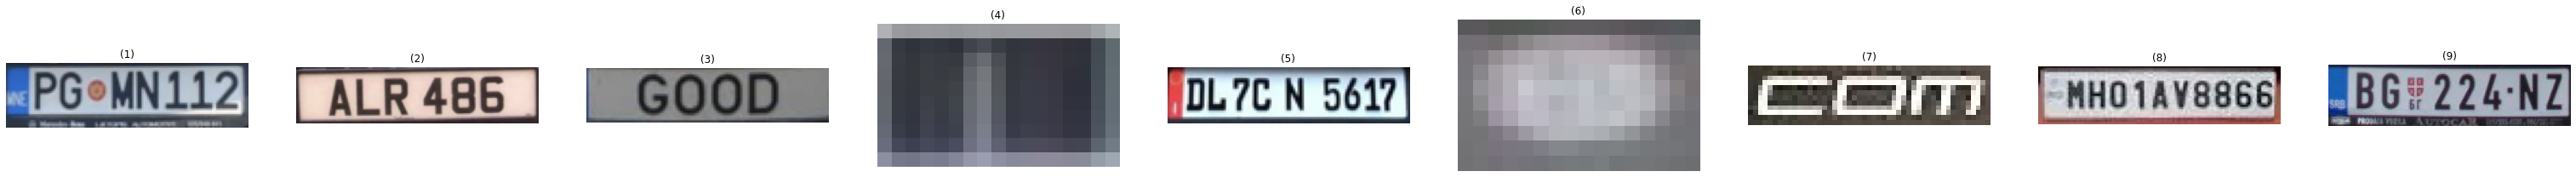

In [203]:
plates = []
for file in os.listdir(os.fsencode("closeCars")):
    filename = os.fsdecode(file)
    img = io.imread("./closeCars/" + filename)
    img = fixRange(img)
    result = []
    processed_img = preprocess(img)
    result += getLicensePlate(processed_img, img)
    if len(result) < 1:
        processed_img = preprocess2(img)
        result += getLicensePlate(processed_img, img)
    if len(result) < 1S:
        processed_img = preprocess3(img)
        result += getLicensePlate(processed_img, img)
    plates += result

show_images(plates)
